In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from zipfile import ZipFile
import requests
import io
import math
import plotly.graph_objects as go
import os
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import io
import pandas as pd


In [2]:

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
response = requests.get(url)
data = pd.read_csv(url, header=None)
numerical_features = [
    "sepal length",
    "sepal width",
    "petal length",
    "petal width",
]
data.columns = numerical_features + ["Class"]

Data exploration

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
 4   Class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None


In [4]:
print(data.head())

   sepal length  sepal width  petal length  petal width        Class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa


Data exploration and plots

In [5]:
continuous_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
print("Continuous Features:")
print(continuous_features)

print("Categorical Features:")
print(categorical_features)

Continuous Features:
['sepal length', 'sepal width', 'petal length', 'petal width']
Categorical Features:
['Class']


In [6]:
# Define the calculate function
def calculate(numeric_vector):
    return {
        "Count": numeric_vector.count(),
        "Miss.": numeric_vector.isna().sum(),
        "Card.": numeric_vector.nunique(),
        "Min": numeric_vector.min(),
        "Q1": numeric_vector.quantile(0.25),
        "Mean": numeric_vector.mean(),
        "Median": numeric_vector.median(),
        "Q3": numeric_vector.quantile(0.75),
        "Max": numeric_vector.max(),
        "SD": numeric_vector.std()
    }

def Plan(df, features):
    numeric_df = df[features] 
    data_quality_plan = pd.DataFrame(columns=["Feature", "Count", "Miss.", "Card.", "Min", "Q1", "Mean", "Median", "Q3", "Max", "SD"])
    for col in numeric_df:
        stats = calculate(numeric_df[col])
        stats["Feature"] = col
        data_quality_plan = pd.concat([data_quality_plan, pd.DataFrame([stats])], ignore_index=True)
    return data_quality_plan


data_quality_plan1 = Plan(data, continuous_features)
data_quality_plan1.loc[:, "Count":"SD"] = data_quality_plan1.loc[:, "Count":"SD"].round(1)

#data_quality_plan1

# Plot the DataFrame
fig = go.Figure(data=[go.Table(
    header=dict(values=list(data_quality_plan1.columns),
                fill_color='#61222D',
                align='left',
                font=dict(color='white')),
    cells=dict(values=[data_quality_plan1[column] for column in data_quality_plan1.columns],
               fill_color='lavender',
               align='left'))])
fig.update_layout(width=1500, height=600)  # Adjust the size of the figure
fig.show()
data_quality_plan1.to_csv("tables/data_quality_plan1.csv", index=False)

C:\Users\tiaan\AppData\Local\Temp\ipykernel_14684\74738848.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_quality_plan = pd.concat([data_quality_plan, pd.DataFrame([stats])], ignore_index=True)


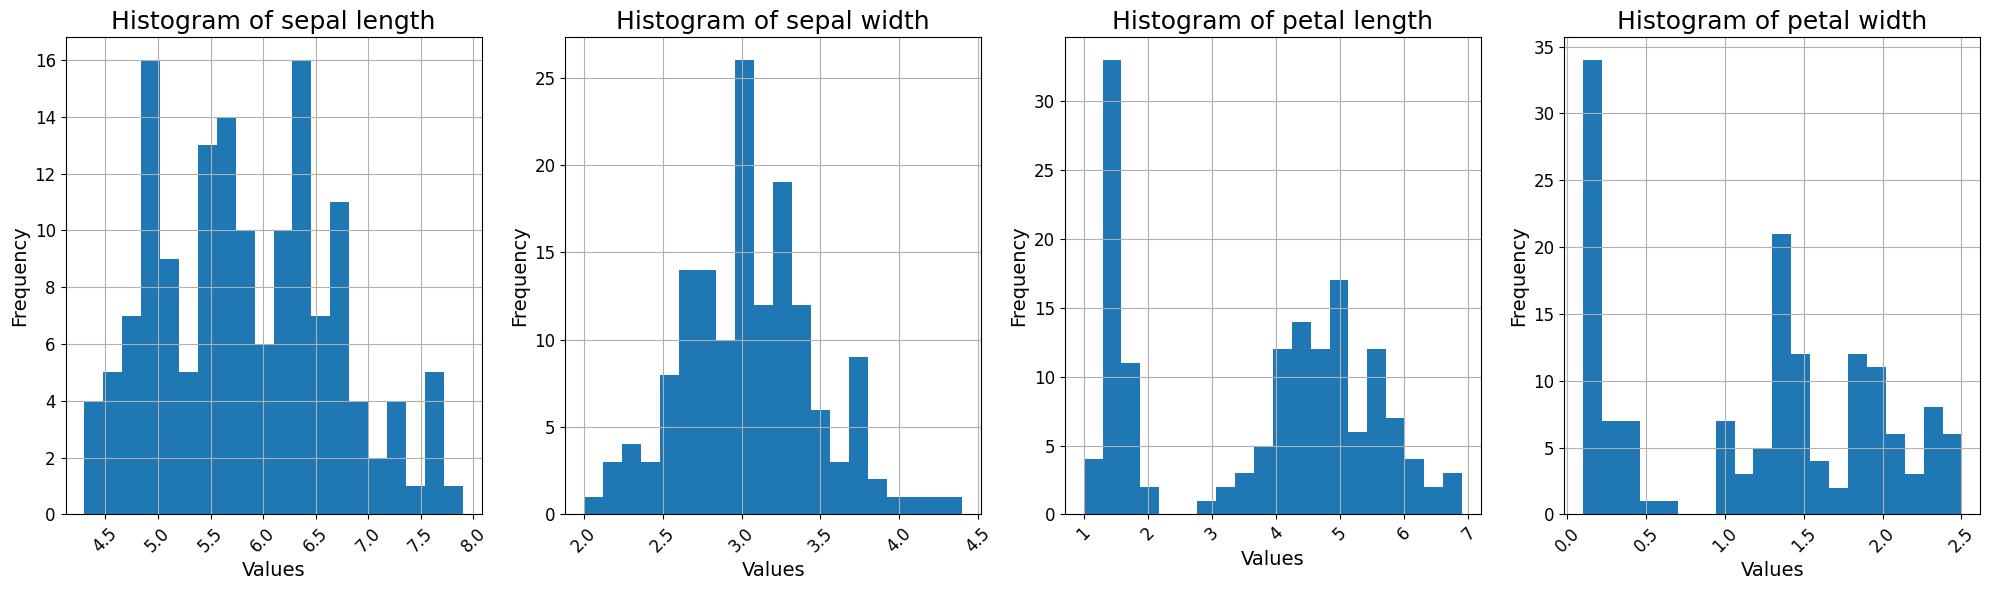

In [7]:
# Determine the number of rows and columns for the subplot grid
n = len(continuous_features)
ncols = 5
nrows = math.ceil(n / ncols)

# Create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 6*nrows))

# Flatten the axes array
axes = axes.flatten()

# Plot histograms for each continuous feature
for i, feature in enumerate(continuous_features):
    data[feature].hist(bins=20, ax=axes[i])
    axes[i].set_title(f'Histogram of {feature}', fontsize=18)
    axes[i].set_xlabel('Values', fontsize=14)
    axes[i].set_ylabel('Frequency', fontsize=14)
    axes[i].tick_params(axis='x', rotation=45, labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

# Remove unused subplots
if n < nrows * ncols:
    for i in range(n, nrows * ncols):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [8]:
# Define the calculate function for categorical features
def calculate_categorical(vector):
    stats = {
        "Count": vector.count(),
        "Miss.": vector.isna().sum(),
        "Card.": vector.nunique()
    }
    
    # Calculate mode and related statistics
    mode_data = vector.mode()
    if len(mode_data) > 0:
        mode_val = mode_data[0]
        mode_count = vector.value_counts().iloc[0]
        stats["Mode"] = mode_val
        stats["Mode Freq"] = mode_count
        stats["Mode %"] = (mode_count / stats["Count"]) * 100
    else:
        stats["Mode"] = np.nan
        stats["Mode Freq"] = np.nan
        stats["Mode %"] = np.nan
    
    # Calculate second mode and related statistics if possible
    if vector.value_counts().shape[0] > 1:
        second_mode_val = vector.value_counts().index[1]
        second_mode_count = vector.value_counts().iloc[1]
        stats["2nd Mode"] = second_mode_val
        stats["2nd Mode Freq"] = second_mode_count
        stats["2nd Mode %"] = (second_mode_count / stats["Count"]) * 100
    else:
        stats["2nd Mode"] = np.nan
        stats["2nd Mode Freq"] = np.nan
        stats["2nd Mode %"] = np.nan

    return stats

def Plan_categorical(df, features):
    categorical_df = df[features] 
    data_quality_plan = pd.DataFrame(columns=["Feature", "Count", "Miss.", "Card.", "Mode", "Mode Freq", "Mode %", "2nd Mode", "2nd Mode Freq", "2nd Mode %"])
    for col in categorical_df:
        stats = calculate_categorical(categorical_df[col])
        stats["Feature"] = col
        data_quality_plan = pd.concat([data_quality_plan, pd.DataFrame([stats])], ignore_index=True)
    return data_quality_plan

data_quality_plan2 = Plan_categorical(data, categorical_features)
data_quality_plan2.loc[:, ["Mode %", "2nd Mode %"]] = data_quality_plan2.loc[:, ["Mode %", "2nd Mode %"]].round(1)
data_quality_plan2.to_csv("tables/data_quality_plan2.csv", index=False)

#data_quality_plan2

# Plot the DataFrame
fig = go.Figure(data=[go.Table(
    header=dict(values=list(data_quality_plan2.columns),
                fill_color='#61222D',
                align='left',
                font=dict(color='white')),
    cells=dict(values=[data_quality_plan2[column] for column in data_quality_plan2.columns],
               fill_color='lavender',
               align='left'))])
fig.update_layout(width=1500, height=800)  # Adjust the size of the figure
fig.show()

C:\Users\tiaan\AppData\Local\Temp\ipykernel_14684\342783405.py:42: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



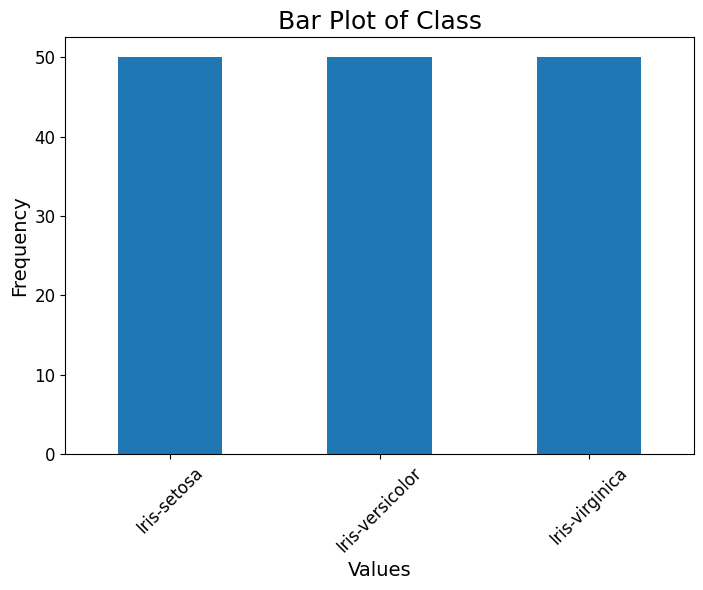

In [9]:
import math
import matplotlib.pyplot as plt

# Assuming categorical_features is defined somewhere in your code
# categorical_features = [...]

# Check if there are any categorical features
if categorical_features:
    n = len(categorical_features)
    ncols = 3  # Change the number of columns to 3
    nrows = math.ceil(n / ncols)

    # Create the subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 6*nrows))

    # Flatten the axes array
    axes = axes.flatten()

    # Plot bar plots for each categorical feature
    for i, feature in enumerate(categorical_features):
        data[feature].value_counts().plot(kind='bar', ax=axes[i])
        axes[i].set_title(f'Bar Plot of {feature}', fontsize=18)
        axes[i].set_xlabel('Values', fontsize=14)
        axes[i].set_ylabel('Frequency', fontsize=14)
        axes[i].tick_params(axis='x', rotation=45, labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)

    # Remove unused subplots
    if n < nrows * ncols:
        for i in range(n, nrows * ncols):
            fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()
else:
    print("No categorical features to plot.")

Data preprocessing

### Remove Low Variance Features:

In [10]:
variances = data[continuous_features].var()
low_variance_features = variances[variances < 0.01].index.tolist()
filtered_continuous_features = [f for f in continuous_features if f not in low_variance_features]
print("Filtered Continuous Features:", filtered_continuous_features)


Filtered Continuous Features: ['sepal length', 'sepal width', 'petal length', 'petal width']


### Correlation Analysis

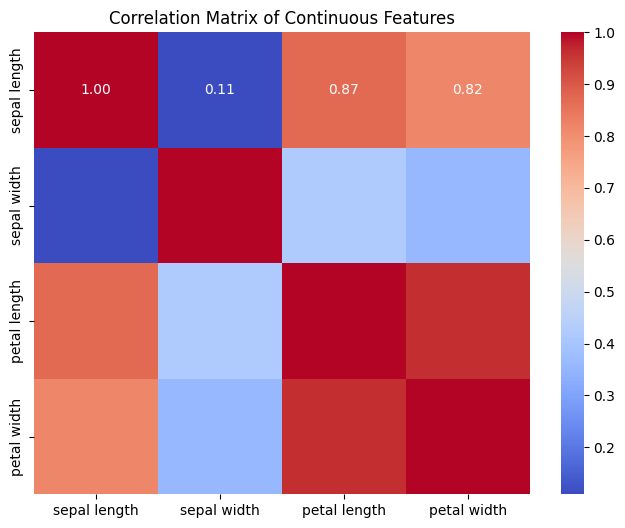

In [11]:
# Calculate correlation matrix
correlation_matrix = data[continuous_features].corr().abs()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Continuous Features')
plt.show()


In [12]:
correlation_matrix = data[filtered_continuous_features].corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
filtered_continuous_features = [f for f in filtered_continuous_features if f not in highly_correlated_features]
print("Features after removing high correlation:", filtered_continuous_features)


Features after removing high correlation: ['sepal length', 'sepal width', 'petal length']


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assuming 'data' is your DataFrame and 'filtered_continuous_features' is a list of feature names
X = data[filtered_continuous_features]

# Encode the 'Class' feature
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Class'])

# Initialize and fit the RandomForestRegressor
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
importance = model.feature_importances_
importance_df = pd.DataFrame({'Feature': filtered_continuous_features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(importance_df)


        Feature  Importance
2  petal length    0.961743
0  sepal length    0.026399
1   sepal width    0.011858


In [14]:
# Select numerical features
#numerical_features = ['age', 'absences', 'G2', 'G3']
X = data[numerical_features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

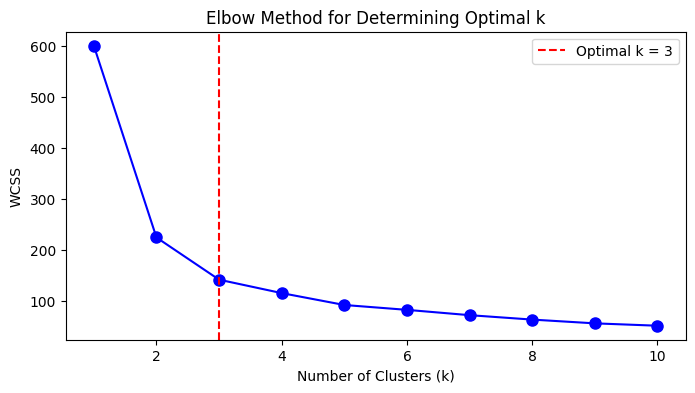

Optimal number of clusters: 3


In [15]:
import time
import numpy as np
import random
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import calinski_harabasz_score
from kneed import KneeLocator
import matplotlib.pyplot as plt



def determine_optimal_clusters(X, max_k=10):
    """
    Determine the optimal number of clusters using the elbow method.

    Args:
        X (np.ndarray): The dataset, where rows are samples and columns are features.
        max_k (int): The maximum number of clusters to consider.

    Returns:
        int: The optimal number of clusters.
    """
    wcss = []
    for i in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    knee_locator = KneeLocator(
        range(1, max_k + 1), wcss, curve="convex", direction="decreasing"
    )
    elbow_point = knee_locator.knee

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, max_k + 1), wcss, 'bo-', markersize=8)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS')
    plt.title('Elbow Method for Determining Optimal k')
    plt.axvline(elbow_point, linestyle='--', color='r', label=f'Optimal k = {elbow_point}')
    plt.legend()
    plt.show()

    if elbow_point is None:
        raise ValueError("KneeLocator could not find an optimal number of clusters.")
    
    return elbow_point


# Determine optimal number of clusters
optimal_clusters = determine_optimal_clusters(X_scaled, max_k=10)
print(f"Optimal number of clusters: {optimal_clusters}")



In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform, cdist
import numpy as np

# K-means clustering
kmeans = KMeans(n_clusters=optimal_clusters, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_wcss = kmeans.inertia_



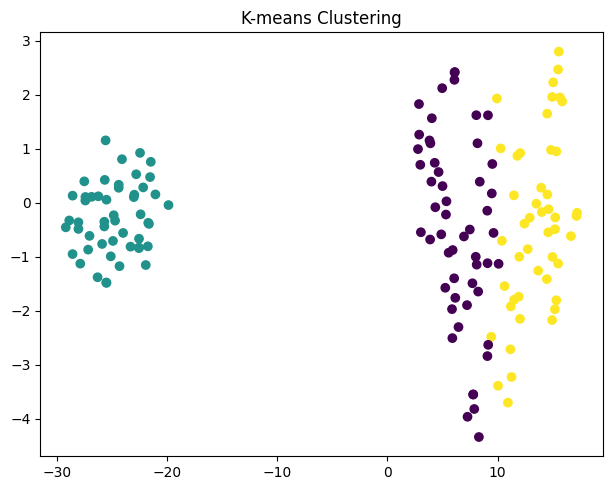

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-means Clustering')

plt.tight_layout()
plt.show()